Dependencies:

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import norm

Performance metrics:

In [2]:
def calculate_performance_metrics(df):
    df['Daily Return'] = df['Portfolio Value'].pct_change().fillna(0)
    cumulative_return = df['Portfolio Value'].iloc[-1] / df['Portfolio Value'].iloc[0] - 1
    annualized_return = (1 + cumulative_return) ** (252 / len(df)) - 1
    sharpe_ratio = np.mean(df['Daily Return']) / np.std(df['Daily Return']) * np.sqrt(252)
    rolling_max = df['Portfolio Value'].cummax()
    drawdown = (df['Portfolio Value'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()
    win_rate = (df['Daily Return'] > 0).sum() / len(df['Daily Return'])
    
    return {
        'CAGR': annualized_return,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Win Rate': win_rate,
        'Total Return': cumulative_return
    }

Fetch data from Yahoo finance:

In [3]:
# Fetch data
def fetch_data(ticker="AAPL", start="2018-01-01", end=None):
    end = end or datetime.today().strftime('%Y-%m-%d')
    return yf.download(ticker, start=start, end=end)

Plot a graph:

In [4]:
# Plot
def plot_performance(df, title="Strategy Performance"):
    df['Portfolio Value'].plot(figsize=(12, 6), title=title)
    plt.ylabel("Portfolio Value")
    plt.grid(True)
    plt.show()

## Strategy 1: Volatility Compression Breakout

In [5]:
# Signal Generation
def generate_volatility_compression_signals(df, bb_window, percentile, holding_period):
    df = df.copy()
    df['MA'] = df['Close'].rolling(window=bb_window).mean()
    df['STD'] = df['Close'].rolling(window=bb_window).std()
    df['Upper'] = df['MA'] + 2 * df['STD']
    df['Lower'] = df['MA'] - 2 * df['STD']
    df['Band Width'] = (df['Upper'] - df['Lower']) / df['MA']

    bandwidth_threshold = df['Band Width'].rolling(window=252).quantile(percentile)
    signals = (df['Band Width'] < bandwidth_threshold).astype(int)

    bandwidth_40th = df['Band Width'].rolling(window=252).quantile(0.40)
    position = [0] * len(signals)
    holding = 0
    for i in range(len(signals)):
        if holding > 0:
            position[i] = 1
            holding -= 1
            if df['Band Width'].iloc[i] > bandwidth_40th.iloc[i]:
                holding = 0  # exit early if expansion starts
        elif signals.iloc[i] == 1:
            holding = holding_period
            position[i] = 1

    return pd.Series(position, index=df.index, name="Signal")

Simple Backtest Strategy

In [6]:
# Simple backtest framework
def backtest_strategy(df, signals):
    if isinstance(signals, pd.DataFrame):
        signals = signals.iloc[:, 0]

    df = df.copy()
    df['Signal'] = signals

    position = df['Signal'].shift(1).fillna(0)
    if isinstance(position, pd.DataFrame):
        position = position.iloc[:, 0]

    df['Position'] = position

    price = df['Close']
    if isinstance(price, pd.DataFrame):
        price = price.iloc[:, 0]

    returns = price.pct_change().fillna(0)
    df['Strategy Return'] = position * returns
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()

    return df



Backtest with Risk Management Refinement Layer:

In [7]:
def backtest_with_risk_management(df, signals, stop_loss=0.03, take_profit=0.06, max_holding=5):
    df = df.copy()
    df['Signal'] = signals
    df['Position'] = 0
    df['Portfolio Value'] = 1.0

    in_trade = False
    entry_price = 0.0
    trade_days = 0

    for i in range(1, len(df)):
        current_close = df['Close'].iloc[i]
        if isinstance(current_close, pd.Series):
            current_close = current_close.iloc[0]  # Ensure scalar

        if df['Signal'].iloc[i] == 1 and not in_trade:
            in_trade = True
            entry_price = current_close
            df.at[df.index[i], 'Position'] = 1
        elif in_trade:
            price = current_close
            change = (price - entry_price) / entry_price

            if change <= -stop_loss or change >= take_profit or trade_days >= max_holding:
                in_trade = False
                trade_days = 0
            else:
                df.at[df.index[i], 'Position'] = 1
                trade_days += 1

    # Ensure both are Series (never accidentally DataFrames)
    close_series = df['Close']
    if isinstance(close_series, pd.DataFrame):
        close_series = close_series.iloc[:, 0]
    close_series = close_series.astype(float)

    position_series = df['Position']
    if isinstance(position_series, pd.DataFrame):
        position_series = position_series.iloc[:, 0]
    position_series = position_series.astype(float)

    returns = close_series.pct_change().fillna(0)
    df['Strategy Return'] = position_series.shift(1).fillna(0) * returns
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()

    return df


### Strategy 1 Feedback Loop AGI for Refinement

In [8]:
# Step 1: Fetch data
df = fetch_data("AAPL", start="2018-01-01")

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Successful Experiment 2 suggested by the AGI:

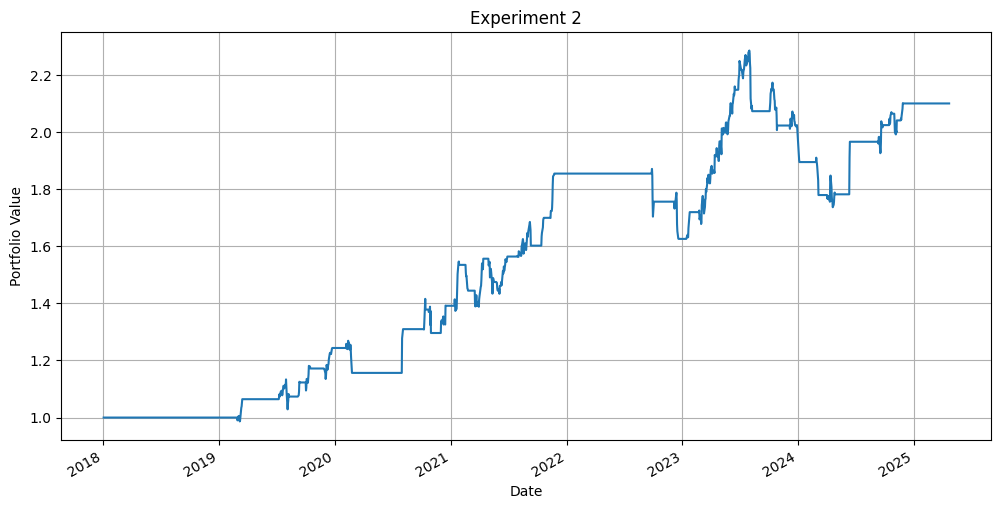

{'CAGR': np.float64(0.10727356357337015), 'Sharpe Ratio': np.float64(0.8678870447865088), 'Max Drawdown': np.float64(-0.240162307190532), 'Win Rate': np.float64(0.13242506811989102), 'Total Return': np.float64(1.1001638044546755)}


In [9]:
signals = generate_volatility_compression_signals(df, bb_window=20, percentile=0.20, holding_period=5)
bt_df1 = backtest_strategy(df, signals)
metrics = calculate_performance_metrics(bt_df1)
plot_performance(bt_df1, title="Experiment 2")
print(metrics)

Experiment 2 Augumented with Risk Management:

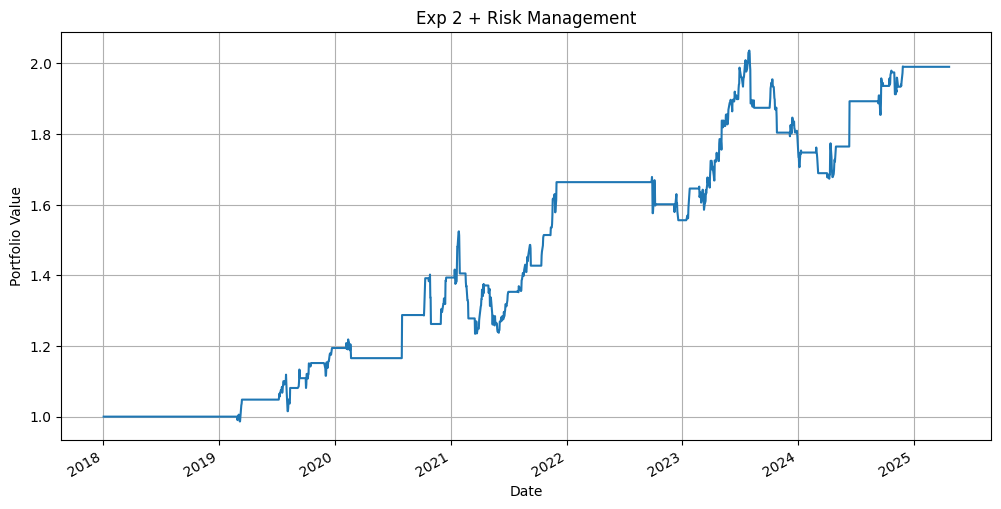

{'CAGR': np.float64(0.09912184823570414), 'Sharpe Ratio': np.float64(0.8166830096426597), 'Max Drawdown': np.float64(-0.19015652041960118), 'Win Rate': np.float64(0.12697547683923704), 'Total Return': np.float64(0.9901480640755376)}


In [10]:
signals = generate_volatility_compression_signals(df, bb_window=20, percentile=0.20, holding_period=5)
bt_df = backtest_with_risk_management(df, signals, stop_loss=0.03, take_profit=0.06)
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Exp 2 + Risk Management")
print(metrics)

💾 Strategy 1 Summary
✅ Locked In Version:
Volatility Compression Breakout (V2)

BB Window: 20

Percentile: 20%

Holding: Up to 5 days

Stop-Loss: 3%

Take-Profit: 6%

## Strategy 2: Fear Factor Fade (VIX-based Contrarian)

Yahoo Finance Data Fetch:
- SPY (S&P 500 ETF) for price/returns
- ^VIX (CBOE Volatility Index) for sentiment

In [11]:
def fetch_vix_spy(start="2015-01-01", end=None):
    end = end or pd.Timestamp.today().strftime('%Y-%m-%d')
    spy = yf.download("SPY", start=start, end=end)['Close']
    spy.name = "SPY"
    vix = yf.download("^VIX", start=start, end=end)['Close']
    vix.name = "VIX"
    df = pd.concat([spy, vix], axis=1).dropna()
    return df

In [12]:
df = fetch_vix_spy()
df = df.rename(columns={"^VIX": "VIX"})
print(df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Ticker             SPY        VIX
Date                             
2015-01-02  172.075180  17.790001
2015-01-05  168.967590  19.920000
2015-01-06  167.376114  21.120001
2015-01-07  169.461823  19.309999
2015-01-08  172.468857  17.010000


Signal Generation

In [13]:
def generate_vix_fade_v2_with_stop(df, vix_window=252, high_percentile=0.90, low_percentile=0.60, stop_loss=-0.035, max_hold=5):
    df = df.copy()
    df['VIX_high'] = df['VIX'].rolling(window=vix_window).quantile(high_percentile)
    df['VIX_low'] = df['VIX'].rolling(window=vix_window).quantile(low_percentile)
    df['SPY_ret'] = df['SPY'].pct_change().fillna(0)

    position = [0] * len(df)
    in_trade = False
    hold_days = 0
    entry_price = 0.0

    for i in range(1, len(df)):
        if not in_trade:
            if df['VIX'].iloc[i] > df['VIX_high'].iloc[i] and df['SPY_ret'].iloc[i] < 0:
                in_trade = True
                hold_days = 1
                entry_price = df['SPY'].iloc[i]
                position[i] = 1
        else:
            hold_days += 1
            current_price = df['SPY'].iloc[i]
            pnl = (current_price - entry_price) / entry_price
            position[i] = 1

            # Exit conditions: VIX calmed, max hold, or SPY dropped too much
            if (
                df['VIX'].iloc[i] < df['VIX_low'].iloc[i]
                or hold_days >= max_hold
                or pnl <= stop_loss
            ):
                in_trade = False
                hold_days = 0

    return pd.Series(position, index=df.index, name="Signal")


Simple backtest framework

In [14]:
def backtest_fear_fade(df, signals):
    df = df.copy()
    df['Signal'] = signals
    df['Position'] = df['Signal'].shift(1).fillna(0)
    df['Strategy Return'] = df['Position'] * df['SPY'].pct_change().fillna(0)
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()
    return df

### Strategy 2 Feedback Loop for AGI

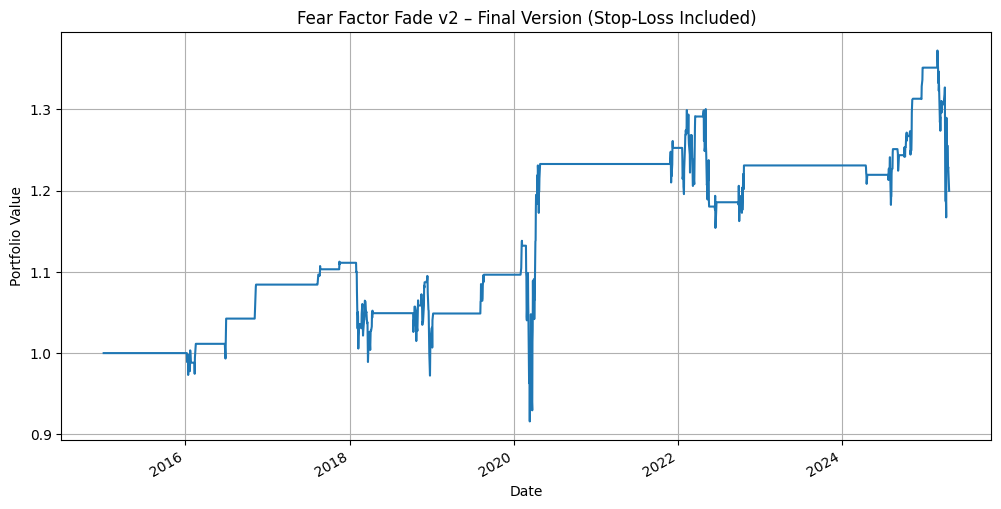

{'CAGR': np.float64(0.017874353915592334), 'Sharpe Ratio': np.float64(0.20690177698378365), 'Max Drawdown': np.float64(-0.195351870975908), 'Win Rate': np.float64(0.07027027027027027), 'Total Return': np.float64(0.19971749326015464)}


In [15]:
signals = generate_vix_fade_v2_with_stop(df)
bt_df2 = backtest_fear_fade(df, signals)
metrics = calculate_performance_metrics(bt_df2)
plot_performance(bt_df2, title="Fear Factor Fade v2 – Final Version (Stop-Loss Included)")
print(metrics)

Final Thoughts on Strategy 2:
✅ Mean-reversion, fear-fade strategy

🧠 Logic grounded in sentiment + behavior

📉 Low-frequency, uncorrelated with breakout logic from Strategy 1

🔒 Stop-loss turned it from "clever but risky" to "viable allocation candidate"

## Strategy 3: Sentiment Mismatch Swing

Adding RSI to Dataframe

In [16]:
def add_rsi(df, period=14):
    delta = df['SPY'].diff()
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    rs = avg_gain / avg_loss

    df['RSI'] = 100 - (100 / (1 + rs))
    return df


Detect Bullish Divergence Signals:

In [17]:
def generate_rsi_divergence_signals(df, lookback=10, holding=5):
    df = df.copy()
    df = add_rsi(df)

    signals = [0] * len(df)
    position = [0] * len(df)
    hold = 0

    for i in range(lookback, len(df)):
        price_now = df['SPY'].iloc[i]
        price_then = df['SPY'].iloc[i - lookback]
        rsi_now = df['RSI'].iloc[i]
        rsi_then = df['RSI'].iloc[i - lookback]

        # Bullish divergence: price down, RSI up
        if price_now < price_then and rsi_now > rsi_then and rsi_now < 50 and not hold:
            hold = holding
            signals[i] = 1

        if hold > 0:
            position[i] = 1
            hold -= 1

    return pd.Series(position, index=df.index, name="Signal")


Dual Divergence Signal

In [18]:
def generate_rsi_divergence_with_trend_filter(df, lookback=10, holding=5):
    df = df.copy()
    df = add_rsi(df)
    df['MA200'] = df['SPY'].rolling(window=200).mean()

    signals = [0] * len(df)
    position = [0] * len(df)
    hold = 0
    direction = 0  # 1 = long, -1 = short

    for i in range(lookback, len(df)):
        price_now = df['SPY'].iloc[i]
        price_then = df['SPY'].iloc[i - lookback]
        rsi_now = df['RSI'].iloc[i]
        rsi_then = df['RSI'].iloc[i - lookback]
        ma200 = df['MA200'].iloc[i]

        # Start new trade if not currently holding
        if hold == 0:
            # Bullish divergence: price down, RSI up, RSI < 50
            if price_now < price_then and rsi_now > rsi_then and rsi_now < 50:
                hold = holding
                direction = 1
                signals[i] = 1

            # Bearish divergence: price up, RSI down, RSI > 50 + SPY below MA200
            elif (
                price_now > price_then
                and rsi_now < rsi_then
                and rsi_now > 50
                and price_now < ma200  # ← trend filter for shorting
            ):
                hold = holding
                direction = -1
                signals[i] = -1

        else:
            signals[i] = direction
            hold -= 1

    return pd.Series(signals, index=df.index, name="Signal")


Dual-Sided Backtest Function

In [19]:
def backtest_dual_side(df, signals):
    df = df.copy()
    df['Signal'] = signals
    df['Position'] = df['Signal'].shift(1).fillna(0)
    df['Strategy Return'] = df['Position'] * df['SPY'].pct_change().fillna(0)
    df['Portfolio Value'] = (1 + df['Strategy Return']).cumprod()
    return df


### Strategy 3 Feedback Loop for AGI

Sentiment Mismatch Swing v1 – Bullish RSI Divergence

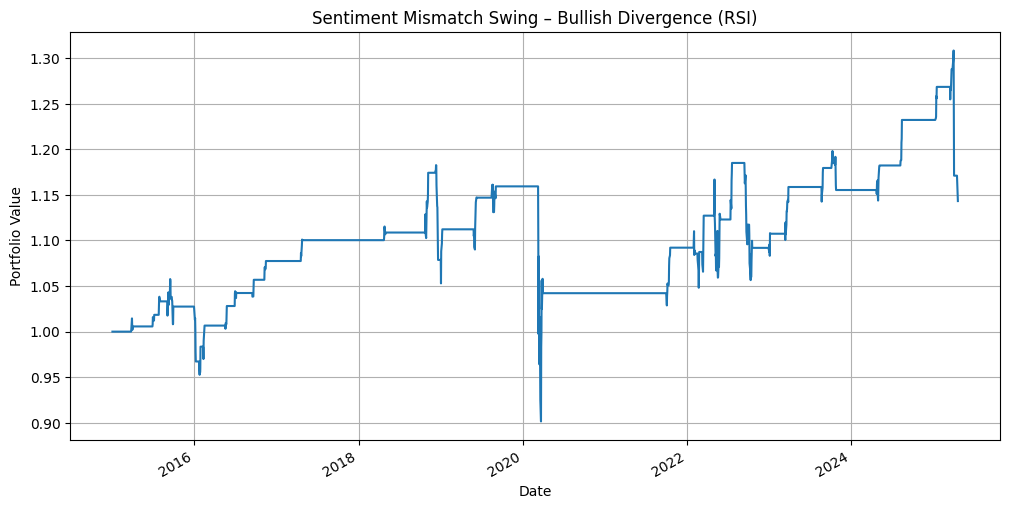

{'CAGR': np.float64(0.013111060494494398), 'Sharpe Ratio': np.float64(0.18304986842077994), 'Max Drawdown': np.float64(-0.2377935767739927), 'Win Rate': np.float64(0.05791505791505792), 'Total Return': np.float64(0.14325200559776063)}


In [20]:
signals = generate_rsi_divergence_signals(df)
bt_df3 = backtest_fear_fade(df, signals)  # we’re still just long/flat
metrics = calculate_performance_metrics(bt_df3)
plot_performance(bt_df3, title="Sentiment Mismatch Swing – Bullish Divergence (RSI)")
print(metrics)

Updated Signal Generator: Bullish + Filtered Bearish

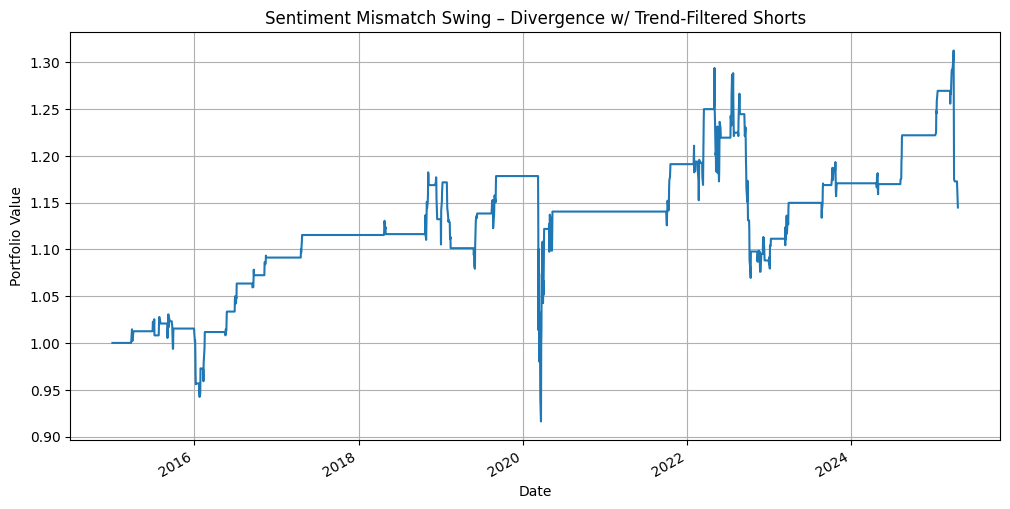

{'CAGR': np.float64(0.013230719756533782), 'Sharpe Ratio': np.float64(0.1790942470850011), 'Max Drawdown': np.float64(-0.22508255944111658), 'Win Rate': np.float64(0.07181467181467181), 'Total Return': np.float64(0.14464057765651162)}


In [21]:
signals = generate_rsi_divergence_with_trend_filter(df)
bt_df = backtest_dual_side(df, signals)
metrics = calculate_performance_metrics(bt_df)
plot_performance(bt_df, title="Sentiment Mismatch Swing – Divergence w/ Trend-Filtered Shorts")
print(metrics)

## Strategy 4: Rolling Reversal (Volatility-Weighted Pullback Entry)

Step 1: ATR + Trend Calculation

In [22]:
def add_trend_and_volatility(df, ma_period=50, atr_period=14):
    df = df.copy()
    df['MA'] = df['SPY'].rolling(window=ma_period).mean()

    high_low = df['SPY'].rolling(2).max() - df['SPY'].rolling(2).min()
    high_close = abs(df['SPY'] - df['SPY'].shift(1))
    tr = pd.concat([high_low, high_close], axis=1).max(axis=1)
    df['ATR'] = tr.rolling(atr_period).mean()

    return df

A refined v3 version with more realistic thresholds and risk management

In [23]:
def generate_rolling_reversal_v3(df, ma_period=50, atr_period=14, atr_window=50,
                                 atr_thresh=0.7, holding=5, stop_loss=0.03):
    df = add_trend_and_volatility(df, ma_period, atr_period)

    df['ATR_Perc'] = df['ATR'].rolling(atr_window).apply(
        lambda x: (x.iloc[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 1.0,
        raw=False
    )

    signals = [0] * len(df)
    hold = 0
    direction = 0
    entry_price = 0

    for i in range(ma_period, len(df)):
        price = df['SPY'].iloc[i]
        ma = df['MA'].iloc[i]
        atr_perc = df['ATR_Perc'].iloc[i]

        # If in trade, check stop-loss or continue
        if hold > 0:
            change = (price - entry_price) / entry_price * direction
            if change <= -stop_loss:
                hold = 0
                direction = 0
            else:
                signals[i] = direction
                hold -= 1
            continue

        # Only enter a new trade if not holding
        if atr_perc <= atr_thresh:
            if price > ma * 0.985 and price < ma:  # Small pullback
                hold = holding
                direction = 1
                entry_price = price
                signals[i] = 1
            elif price < ma and price > ma * 1.015:  # short entry
                hold = holding
                direction = -1
                entry_price = price
                signals[i] = -1

    return pd.Series(signals, index=df.index, name="Signal")


### Strategy 4 Feedback Loop for AGI

Signal distribution:
 Signal
0    2311
1     279
Name: count, dtype: int64


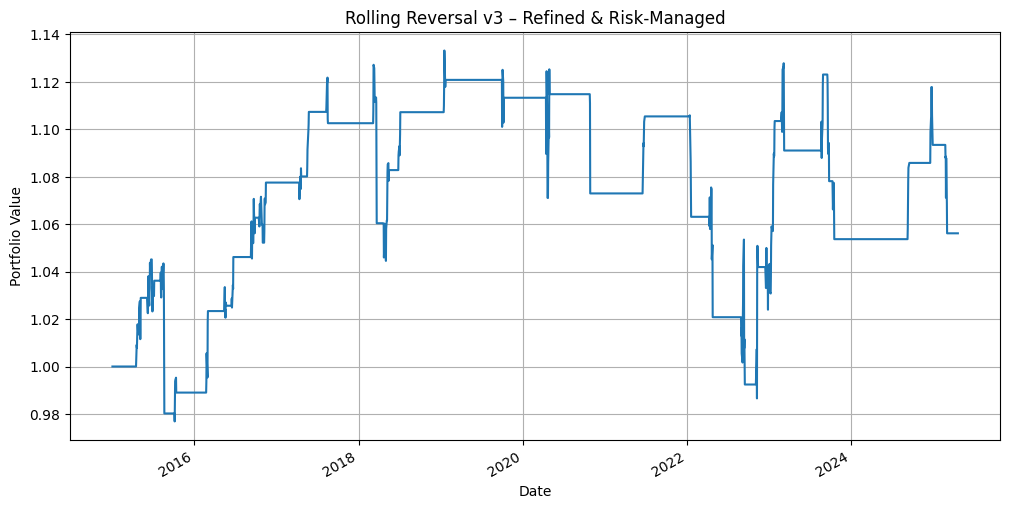

{'CAGR': np.float64(0.0053270199269639384), 'Sharpe Ratio': np.float64(0.12359146989316568), 'Max Drawdown': np.float64(-0.1293651881671153), 'Win Rate': np.float64(0.06023166023166023), 'Total Return': np.float64(0.05612295785962429)}


In [24]:
signals = generate_rolling_reversal_v3(df, atr_thresh=0.5)
print("Signal distribution:\n", signals.value_counts())

bt_df4 = backtest_dual_side(df, signals)
metrics = calculate_performance_metrics(bt_df4)
plot_performance(bt_df4, title="Rolling Reversal v3 – Refined & Risk-Managed")
print(metrics)

## Ensemble Allocator

Performance Metrics Function:

In [25]:
def evaluate_portfolio(series):
    daily_ret = series.pct_change().dropna()
    cagr = (series.iloc[-1] / series.iloc[0]) ** (252 / len(series)) - 1
    sharpe = daily_ret.mean() / daily_ret.std() * np.sqrt(252)
    max_dd = (series / series.cummax() - 1).min()
    return {
        'CAGR': cagr,
        'Sharpe': sharpe,
        'Max Drawdown': max_dd,
        'Total Return': series.iloc[-1] - 1
    }

In [26]:
# These are the Portfolio Value series from each backtest:
s1 = bt_df1['Portfolio Value']
s2 = bt_df2['Portfolio Value']
s3 = bt_df3['Portfolio Value']
s4 = bt_df4['Portfolio Value']

combined_df = pd.concat([s1, s2, s3, s4], axis=1)
combined_df.columns = ['S1', 'S2', 'S3', 'S4']
combined_df = combined_df.dropna()

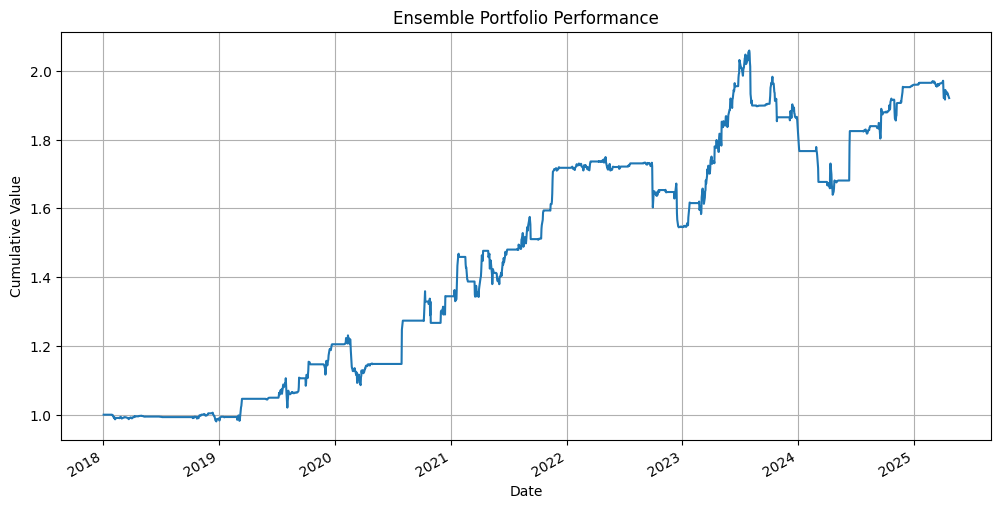

{'CAGR': np.float64(0.0938563546426936), 'Sharpe': np.float64(0.8777424700113964), 'Max Drawdown': np.float64(-0.20379271488470474), 'Total Return': np.float64(0.9210751881734212)}


In [27]:
returns = combined_df.pct_change().dropna()
sharpes = returns.mean() / returns.std() * np.sqrt(252)
weights = sharpes / sharpes.sum()

ensemble_returns = (returns * weights).sum(axis=1)
ensemble_portfolio = (1 + ensemble_returns).cumprod()

ensemble_portfolio.plot(title="Ensemble Portfolio Performance", figsize=(12,6))
plt.grid(True)
plt.ylabel("Cumulative Value")
plt.show()
print(evaluate_portfolio(ensemble_portfolio))

HRP Allocator Function:

In [30]:
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd

def correl_dist(corr):
    return np.sqrt(0.5 * (1 - corr))

def get_hrp_allocation(returns: pd.DataFrame):
    # Step 1: Compute correlation + distance
    corr = returns.corr()
    dist = correl_dist(corr)

    # Step 2: Hierarchical clustering
    link = linkage(squareform(dist), method='single')

    # Step 3: Quasi-diagonalize
    sort_ix = get_quasi_diag(link)
    sorted_returns = returns.iloc[:, sort_ix]

    # Step 4: Recursive bisection allocation
    weights = pd.Series(1, index=sorted_returns.columns)
    clustered = [sorted_returns.columns]

    while clustered:
        sub = clustered.pop(0)
        if len(sub) == 1:
            continue
        split = int(len(sub) / 2)
        left, right = sub[:split], sub[split:]

        var_left = get_cluster_var(returns, left)
        var_right = get_cluster_var(returns, right)

        alloc = 1.0 * var_right / (var_left + var_right)
        weights[left] *= alloc
        weights[right] *= 1 - alloc
        clustered += [left, right]

    return weights / weights.sum()

def get_quasi_diag(link):
    sort_ix = pd.Series([int(link[-1, 0]), int(link[-1, 1])])
    num_items = link.shape[0] + 1

    while sort_ix.max() >= num_items:
        sort_ix.index = range(0, sort_ix.shape[0] * 2, 2)
        df0 = sort_ix[sort_ix >= num_items].astype(int)
        i = df0.index
        j = df0.values - num_items

        left = link[j, 0].astype(int)
        right = link[j, 1].astype(int)

        sort_ix[i] = left
        df1 = pd.Series(right, index=i + 1)

        sort_ix = pd.concat([sort_ix, df1])
        sort_ix = sort_ix.sort_index()

    return sort_ix.astype(int).values

def get_cluster_var(returns, cluster_cols):
    return returns[cluster_cols].cov().values.dot(
        np.ones(len(cluster_cols))
    ).dot(np.ones(len(cluster_cols))) / (len(cluster_cols) ** 2)


C:\Users\spihc\AppData\Local\Temp\ipykernel_52860\2554637918.py:36: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.70181787 0.70181787]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  weights[left] *= alloc


HRP Weights:
 S1    0.123128
S4    0.578690
S2    0.114052
S3    0.184130
dtype: float64


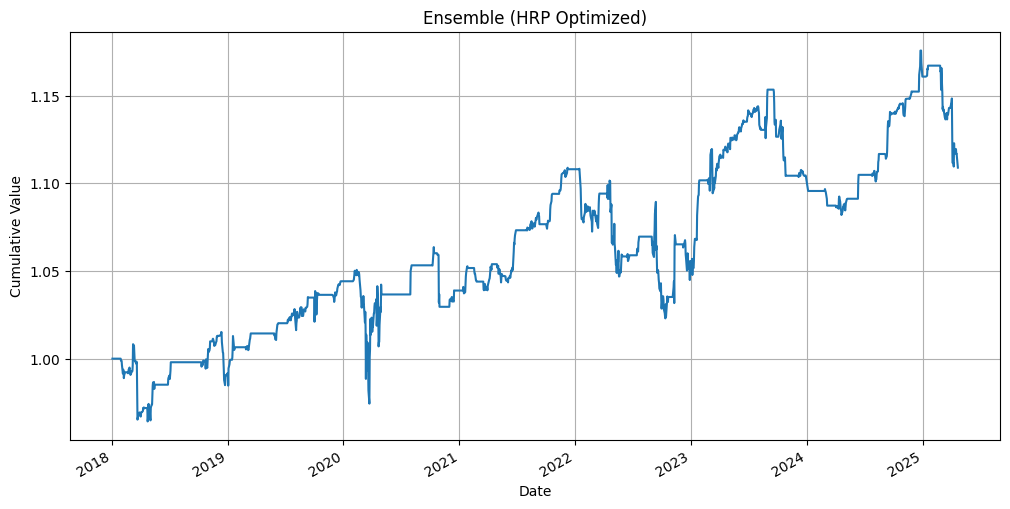

{'CAGR': np.float64(0.014310049862534147), 'Sharpe': np.float64(0.3000099852858138), 'Max Drawdown': np.float64(-0.07748231702340025), 'Total Return': np.float64(0.10894291602220352)}


In [31]:
returns = combined_df.pct_change().dropna()
hrp_weights = get_hrp_allocation(returns)
print("HRP Weights:\n", hrp_weights)

ensemble_returns = (returns * hrp_weights).sum(axis=1)
ensemble_portfolio = (1 + ensemble_returns).cumprod()

ensemble_portfolio.plot(title="Ensemble (HRP Optimized)", figsize=(12,6))
plt.grid(True)
plt.ylabel("Cumulative Value")
plt.show()

print(evaluate_portfolio(ensemble_portfolio))

## Position Sizer Module

In [32]:
def position_size(volatility, max_risk=0.01):
    """
    Allocates capital based on inverse volatility.
    max_risk = max % of capital risked on a single trade
    """
    base_vol = 0.02  # benchmark daily vol (e.g. SPY)
    size = max_risk * (base_vol / volatility)
    return min(size, 1.0)  # cap at 100% of portfolio

In [37]:
class AlphaOverlay:
    def __init__(self, df):
        self.df = df.copy()

        # Ensure ATR_Perc is computed
        if 'ATR_Perc' not in self.df.columns:
            atr = self.df['SPY'].rolling(14).std()
            self.df['ATR_Perc'] = atr.rolling(50).apply(
                lambda x: (x.iloc[-1] - x.min()) / (x.max() - x.min()) if (x.max() - x.min()) > 0 else 1.0,
                raw=False
            )

    def trend(self, ma_period=200):
        return self.df['SPY'] > self.df['SPY'].rolling(ma_period).mean()

    def low_volatility(self, threshold=0.7):
        return self.df['ATR_Perc'] < threshold

    def volume_confirmed(self):
        return self.df['Volume'] > self.df['Volume'].rolling(20).mean()

    def apply(self, signal, filters: list):
        condition = np.ones(len(signal), dtype=bool)
        for f in filters:
            condition &= f
        signal[~condition] = 0
        return signal


In [38]:
overlay = AlphaOverlay(df)
filtered_signals = overlay.apply(signals, [
    overlay.trend(ma_period=200),
    overlay.low_volatility(threshold=0.7)
])

Trade Router

In [51]:
# execution_broker.py

from ib_insync import *
import time
import asyncio

class ExecutionBroker:
    def __init__(self, mode='paper', capital=100_000, host='127.0.0.1', port=7497, client_id=123):
        self.mode = mode
        self.cash = capital
        self.positions = {}  # {ticker: size}

        if mode in ['paper', 'live']:
            self.ib = IB()
            if asyncio.get_event_loop().is_running():
                # Jupyter-safe async connection
                future = asyncio.ensure_future(self.ib.connectAsync(host, port, clientId=client_id))
                while not self.ib.isConnected():
                    time.sleep(0.1)
            else:
                self.ib.connect(host, port, clientId=client_id)
            print(f"✅ Connected to IBKR ({mode.upper()})")

    def submit_order(self, ticker: str, signal: int, price=None, size=None):
        if signal == 0:
            return

        if self.mode == 'backtest':
            self._simulate_order(ticker, signal, price, size)
        else:
            self._submit_ib_order(ticker, signal, size)

    def _simulate_order(self, ticker, signal, price, size):
        size = size or int(self.cash * 0.01 / price)
        if signal == 1:
            self.positions[ticker] = self.positions.get(ticker, 0) + size
            self.cash -= size * price
        elif signal == -1:
            size = min(size or self.positions.get(ticker, 0), self.positions.get(ticker, 0))
            self.positions[ticker] -= size
            self.cash += size * price

        print(f"[SIM] {'BUY' if signal == 1 else 'SELL'} {size} {ticker} @ {price:.2f}")

    def _submit_ib_order(self, ticker, signal, size):
        contract = Stock(ticker, 'SMART', 'USD')
        self.ib.qualifyContracts(contract)

        action = 'BUY' if signal == 1 else 'SELL'
        size = size or 1
        order = MarketOrder(action, size)
        trade = self.ib.placeOrder(contract, order)

        print(f"[IBKR] {action} {size} {ticker} submitted...")

    # Async-friendly logic (Jupyter safe)
        if asyncio.get_event_loop().is_running():
            def on_fill(trade, fill):
                print(f"[IBKR] ✅ Filled: {fill.execution}")
            trade.filledEvent += on_fill
        else:
            while not trade.isDone():
                self.ib.waitOnUpdate()
            print(f"[IBKR] ✅ Order status: {trade.orderStatus.status}")

        def disconnect(self):
            if self.mode in ['paper', 'live']:
                self.ib.disconnect()
                print("❎ Disconnected from IBKR.")


In [ ]:
broker = ExecutionBroker(mode='paper', client_id=161)
